In [303]:
import sys
import importlib
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import *

In [304]:
# Get analytical solution of the BVP for given q0, p0 and t
def analytic_solution(iv, t, w=1):
    q0 = iv[:,None,0] 
    p0 = iv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    return torch.stack((x, y), dim=2)

In [305]:
def get_data(num_iv=10, num_t=10, Tmax=5):
    iv = np.random.uniform(low=-1, high=1, size=(num_iv, 2)).astype(np.float32)

    if num_t > 1:
        t = np.random.uniform(low=0, high=Tmax, size=(num_t, 1)).astype(np.float32)
    else:
        t = np.array([Tmax])[:,None].astype(np.float32)

    y = analytic_solution(iv, t)
    X = (iv, t)

    
    return X, y

In [306]:
X_train, y_train = get_data(num_iv=3, num_t=1, Tmax=0.01)
X_test, y_test = get_data(num_iv=3, num_t=1, Tmax=0.01)

print(X_train[0].shape)

# X_test, y_test = get_data()
# X_train, y_train = get_data()

(3, 2)


Step 	 Train loss 	 Test loss
20 	 [2.57e-05] 	 [4.90e-05] 	 New best model!
40 	 [1.64e-05] 	 [4.57e-05] 	 New best model!
60 	 [7.55e-06] 	 [4.17e-05] 	 New best model!
80 	 [6.64e-06] 	 [3.46e-05] 	 New best model!
100 	 [1.61e-06] 	 [6.90e-06] 	 New best model!
120 	 [2.45e-07] 	 [8.36e-07] 	 New best model!
140 	 [2.93e-08] 	 [1.44e-07] 	 New best model!
160 	 [3.39e-09] 	 [1.41e-08] 	 New best model!
180 	 [4.23e-10] 	 [2.03e-09] 	 New best model!
200 	 [5.52e-11] 	 [2.24e-10] 	 New best model!
Best training loss: 3.505649763535512e-12


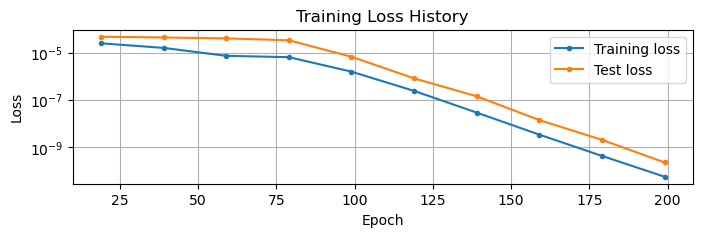

In [307]:
net = DeepONet([40, 40, 40], [40, 40, 40], activation='htanh', scheme=3)
model = Model(X_train, y_train, X_test, y_test, net)
model.train(iterations=200)
model.plot_losshistory()

In [308]:

def plot_energy(model, q=1, p=1, Tmax=1, dpi=100):
 
    iv = np.array([[q, p]], dtype=np.float32)
    
    t = np.linspace(0, Tmax, 20).reshape(-1, 1)
    u = model.predict(iv, t)

    E = torch.linalg.norm(u, axis=-1)[0,:]**2/2
    
    
    _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
    ax.set_title(f'Total Energy of DeepONet Prediction $(q_0, p_0)$=({q}, {p})')
    ax.plot(t, np.ones_like(t)*(q**2 + p**2)/2, alpha=0.5, linewidth=5, label='True energy')
    ax.plot(t, E.detach(), '--', alpha=0.8, linewidth=3,  label='DeepONet energy')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel("t")
    ax.set_ylabel("Total energy")
    plt.show()

#plot_energy(model)

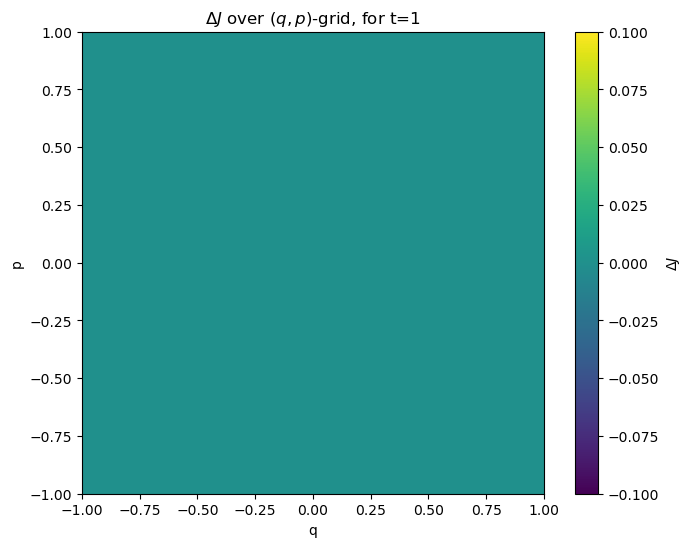

In [309]:
def plot_symplecticity(model, T=1, num_pts=100):

                
    grid_points = torch.linspace(-1, 1, num_pts, requires_grad=True, dtype=torch.float32)
    mesh = torch.cartesian_prod(grid_points, grid_points)
    
    t = torch.tensor([T], requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    
    u = model.net(mesh, t)[:,0,:]    


    D = torch.stack([grad(u[:,i], mesh, grad_outputs=torch.ones_like(u[:,i]), retain_graph=True)[0] for i in range(u.shape[1])], axis=-1)
    D = D.squeeze(1)
    J = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)

    DTJD = torch.matmul(D.transpose(1, 2), torch.matmul(J, D))
    deltaJ = torch.linalg.norm(DTJD - J, ord=2, dim=(1, 2)).numpy().reshape(num_pts, num_pts)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(deltaJ, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    plt.colorbar(label='$\Delta J$')
    plt.title("$\Delta J$ over $(q,p)$-grid, for t=" + f"{T}")
    plt.xlabel('q')
    plt.ylabel('p')
    plt.show()

plot_symplecticity(model, num_pts=10)

In [310]:
def plot_predictions(pred, true, t, iv, title='Prediction'):


        # Plot prediction vs. solution
        fig, axes = plt.subplots(2, 2, figsize=(20, 4), dpi=150)

        axes[0][0].set_title(title)
        axes[0][1].set_title('Error')
        
        handles, labels = [], []
        
        for k in range(axes.shape[0]):
            for l in range(pred.shape[0]):
                
                label = '({:.1f}, {:.1f})'.format(iv[l, 0], iv[l, 1])
                axes[k][0].plot(t, true[l, :, k], label=label, alpha=0.5, linewidth=5)
                axes[k][0].plot(t, pred[l, :, k].detach(), '--', c='k')
                line, = axes[k][1].plot(t, true[l, :, k] - pred[l, :, k].detach(), label=label, linewidth=2)

                # Store handles and labels only once
                if k == 0:
                    handles.append(line)
                    labels.append(label)

            axes[k][0].grid(True)
            axes[k][1].grid(True)

        axes[k][0].set_xlabel("t")
        axes[k][1].set_xlabel("t")

        # Create a shared legend
        fig.legend(handles, labels, loc="upper center", ncol=len(labels), fontsize=10)

        plt.show()

In [311]:
def plot_full_predictions(model, Tmax, num_iv=3):
        
        iv = np.random.uniform(low=-1, high=1, size=(num_iv, 2)).astype(np.float32)
        t = np.linspace(0, Tmax, 100)
        pred  = model.predict(iv, t[:,None])
        true = analytic_solution(iv, t[:,None])        
        plot_predictions(pred, true, t, iv)
        
#plot_full_predictions(model, Tmax=5)

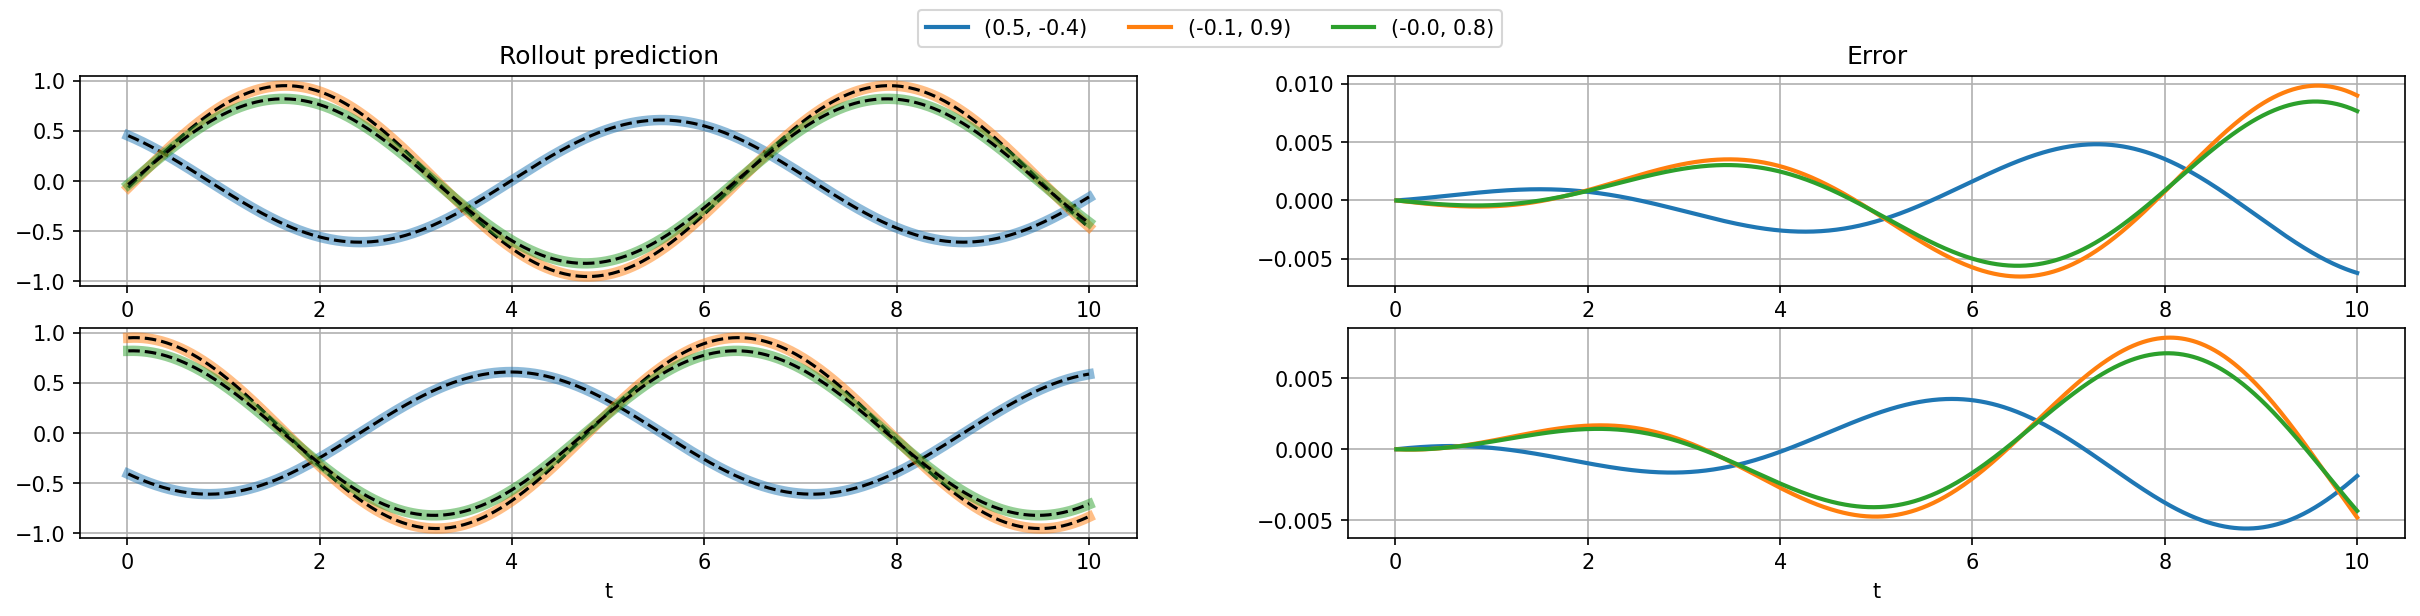

In [312]:
def plot_rollout_predictions(model, h=0.01, iters=1000, num_iv=3):

    T = h * iters
    t = np.linspace(h, T, iters+1)
    h = torch.tensor([[h]], dtype=torch.float32)
    
    iv = np.random.uniform(low=-1, high=1, size=(num_iv, 2)).astype(np.float32)
    conj_momenta = model.predict(model.format(iv), h)
    
    pred = conj_momenta.clone()
    
    for _ in range(iters):
        conj_momenta = model.predict(conj_momenta.squeeze(1), h)
        pred = torch.concatenate((pred, conj_momenta), axis=1)
        
    true = analytic_solution(iv, t.reshape(-1, 1))                    
    plot_predictions(pred, true, t, iv, title='Rollout prediction')

plot_rollout_predictions(model, iters=1000)